The [lvlspy API](https://pypi.org/project/lvlspy/) was developed as an easy-to-use tool set that can handle atomic and nuclear level data to facilitate calculations; with full tutorials found [here](https://github.com/jaadt7/lvlspy_tutorial). 

This notebook utlizies the API to calculate the effective transition rate between the isomeric and ground state of $^{26}\mathrm{Al}$, replicating the results found in [Gupta and Meyer](https://journals.aps.org/prc/abstract/10.1103/PhysRevC.64.025805).

To start things off, we check and (quietly) install any missing required python packages and import them.

In [35]:
import sys, subprocess,pkg_resources,io,requests
#required = {'numpy','matplotlib','lvlspy','ipython','tabulate'}
#installed = {pkg.key for pkg in pkg_resources.working_set}
#missing = required - installed

#f missing:
#    subprocess.check_call([sys.executable,'-m','pip','install','--quiet',*missing])

import copy
import heapq
import tabulate
import numpy as np
import lvlspy.spcoll as lc
import scipy.special as spc
import lvlspy.transition as lt
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from gslconsts.consts import *
from IPython.display import HTML, display, Math

We define the generalized functions according to the methods defined in the aforementioned paper. The transfer properties function takes the rate matrix as input and extracts the Destruction Matrix diagonal, and sets up the Transfer matrix and the Production vectors. In the paper, the 'ij' subscripts refer to transitions from level 'i' into level 'j'. This however does not correspond to the 'ith' row and 'jth' column of the matrix. The index swap in the function takes care of this change.

In the lambda_effective function, the effective decay rate and the excitation rate are calculated between the ground and isomeric state. However, this notebook deviates from the method described in the paper by ignoring the approximation surrounding $(I - F^{T})^{-1}$ and calculates it directly. This leads to a change of form for $\lambda_{12}^{eff}$ and $\lambda_{21}^{eff}$ to $\Lambda_{1}(1 - (f_{1}^{in})^{T}(I - F^{T})^{-1})f_{1}^{out}$ and $\Lambda_{2}(f_{1}^{in})^{T}(I - F^{T})^{-1}f_{2}^{out}$ respectively.

The gamma_calculator function calculates $\Gamma_{q}^{in}$ and $\Gamma_{q}^{out}$ using the transfer properties.

The f's and Newton-Raphson functions are related to another and are used to solve coupled systems.

In [90]:
def rate_mag(E_i, E_f, j, A):
    '''
    Calculate the magnetic transition rate between two states

    Args:
    - E_i: energy of the initial state (in keV)
    - E_f: energy of the final state (in keV)
    - j  : the angular momentum of the state
    - A  : mass number


    Returns:
    - The magnetic contribution to the Weisskopf estimate between the two states
    '''
    dE = E_i - E_f

    return(
        (1.9 * (j + 1)/(j * np.power(spc.factorial2(2*j+1),2)))
        * np.power(3.0 / (j + 3.0),2)
        * np.power(dE/197000.0,2*j + 1)
        * np.power(1.2 * np.power(A, 1.0/3.0), 2*j - 2)
        * GSL_CONST_NUM_ZETTA
    )

def rate_elec(E_i, E_f, j, A):
    '''
    Calculate the electric transition rate between two states

    Args:
    - E_i: energy of the initial state (in keV)
    - E_f: energy of the final state (in keV)
    - j  : the angular momentum of the state
    - A  : mass number


    Returns:
    - The electric contribution to the Weisskopf estimate between the two states
    '''
    
    dE = E_i - E_f

    return (
        (4.4 * (j + 1) / (j * np.power(spc.factorial2(2 * j + 1), 2)))
        * np.power(3.0 / (j + 3.0), 2)
        * np.power(dE / 197000.0, 2 * j + 1)
        * np.power(1.2 * np.power(A, 1.0 / 3.0), 2 * j)
        * GSL_CONST_NUM_ZETTA
    )



def weisskopf_estimate(E_i, E_f, J_i, J_f,P_i,P_f, A):
    """
    Calculates the Weisskopf estimate for a transition between two states.

    Args:
    - E_i: energy of the initial state (in keV)
    - E_f: energy of the final state (in keV)
    - J_i: total angular momentum of the initial state
    - J_f: total angular momentum of the final state
    - P_i: parity of initial state
    - P_f: parity of final state
    - A  : mass number


    Returns:
    - The total Weisskopf estimate for the transition rate (in per second)
    """

    diff = int(J_i - J_f)
    sum = int(J_i + J_f)

    j = range(max(1,abs(diff)),sum + 1) #range of photon angular momentum

    W = 0

    for jj in j:
        if np.power(-1,jj)*P_i == P_f:
            r = rate_elec(E_i,E_f,jj,A)
            W += r
        else:
            r = rate_mag(E_i,E_f,jj,A)
            W += r

    return W/10
# this function calculates the transfer properties required to calculate the various 
# properties this notebook will pace through########################################
def transfer_properties(rate_matrix):
    
    n = len(rate_matrix)
    
    lambda_1_in = rate_matrix[0,2:n]
    lambda_2_in = rate_matrix[1,2:n]

    lambda_1_out = rate_matrix[2:n,0]
    lambda_2_out = rate_matrix[2:n,1]

    LAMBDA = np.diag(rate_matrix)
    
    f1_out = lambda_1_out/LAMBDA[0]
    f2_out = lambda_2_out/LAMBDA[1]

    f1_in = lambda_1_in/LAMBDA[2:n]
    f2_in = lambda_2_in/LAMBDA[2:n]

    F = rate_matrix.T
    
    F = F[2:n,2:n]
    F = F/LAMBDA[2:n,None] #This only works if the arrays are numpy arrays
    
    np.fill_diagonal(F,0.0)
  
    return F,f1_in,f1_out,f2_in,f2_out,LAMBDA
########################################################################################################
#This function calculates the effective transition rates in and out between the ground and isomer states
def lambda_effective(T,sp):

    rate_matrix = np.abs(sp.compute_rate_matrix(T))
    F,f1_in,f1_out,f2_in,f2_out,LAMBDA = transfer_properties(rate_matrix)
    n = len(F)
    #Lambda_21_eff
    l_21 =  LAMBDA[1]* np.matmul(f1_in,np.matmul(np.linalg.inv(np.identity(n) - F.T),f2_out))
    #Lambda_12_eff
    l_12 = LAMBDA[0]*(1.0 - np.matmul(f1_in,np.matmul(np.linalg.inv(np.identity(n) - F.T),f1_out)))
            
    return l_12,l_21
##############################################################################################################
#This function calculates the cascade probabilites in and out of the groud state and isomer
def gamma_calculator(T,sp):
    rate_matrix = np.abs(sp.compute_rate_matrix(T))
    F,f1_in,f1_out,f2_in,f2_out,LAMBDA = transfer_properties(rate_matrix)

    n = len(F)

    #gamma in
    g1_in = np.matmul(np.linalg.inv(np.identity(n) - F),f1_in)
    g2_in = np.matmul(np.linalg.inv(np.identity(n) - F),f2_in)

    #gamma out
    g1_out = np.matmul(np.linalg.inv(np.identity(n) - F.T),f1_out)
    g2_out = np.matmul(np.linalg.inv(np.identity(n) - F.T),f2_out)

    return g1_out,g1_in,g2_out,g2_in
##############################################################################################
# This block is responsible for solving the 2 level system####################################
def f1(Y_guess,Y_old,dt,l12,l21):
    return Y_guess[0]*(dt*l12 + 1.0) - dt*l21*Y_guess[1] - Y_old[0]

def f2(Y_guess,Y_old,dt,l12,l21):
    return Y_guess[1]*(1.0 + dt*l21) - dt*l12*Y_guess[0] - Y_old[1]

def newton_raphson(t,tol,Y,l12,l21):
    Y_guess = Y_old   = Y
    
    n = len(t)
    
    delta = np.ones(2)

    for i in range(1,n):
        dt = t[i] - t[i-1]
        #matrix A changes with each dt
        A = np.array([[1.0 + dt*l12,-dt*l21],[-dt*l12,1.0 + dt*l21]])
        while (max(abs(delta)) >= tol):
            b = np.array([-f1(Y_guess,Y_old,dt,l12,l21),-f2(Y_guess,Y_old,dt,l12,l21)])
            delta = np.linalg.solve(A,b)
            Y_guess += delta            
        
        delta = np.ones(2) #reset the delta's to make sure the while loop runs a calculation
        Y_old = Y_guess
        Y = np.vstack((Y,Y_old))
        
    return Y
#################################################################################################
# This definition is responsible for calculating the weights used to solve the ensemble system
def ensemble_weights(eq_prob,g1_in,g2_in):
    n = len(eq_prob)
    w_1,w_2,R_1k,R_2k = np.empty(n),np.empty(n),np.empty(n-2),np.empty(n-2)
    for i in range(n-2):
        R_1k[i] = eq_prob[i+2]/eq_prob[0] 
        R_2k[i] = eq_prob[i+2]/eq_prob[1]
    
    for i in range(n):
        if i == 0:
            w_1[i] = 1.0
            w_2[i] = 0.0
        elif i == 1:
            w_1[i] = 0.0
            w_2[i] = 1.0
        else:
            w_1[i] = g1_in[i-2]*R_1k[i-2]
            w_2[i] = g2_in[i-2]*R_2k[i-2]      


    W_1,W_2 = np.sum(w_1),np.sum(w_2)
    #partition functions for ground and isomer
    G1 = 11*W_1 #ground state has multiplicity 11 (2J + 1)
    G2 = W_2    #isomer has multiplicity 1 (2J +1)
    return w_1,w_2,W_1,W_2,R_1k,R_2k,G1,G2
############################################################################################
##### THis block is the of functions related to solving the whole reaction network
def f_vector(y_dt,y_i,A):
    return np.matmul(A,y_dt) - y_i

def nefraf_matrix(t,n_rows,tol,y0,A):
    y_result = np.empty([n_rows,len(t)])
    y_result[:,0] = y0

    I = np.identity(n_rows)
    for i in range(1,len(t)):
        delta = np.ones(n_rows)
        y_guess = y_old = y_result[:,i-1]
        dt = t[i] - t[i-1]
        mat_A = I - dt*A
        while max(abs(delta)) > tol:
           delta = np.linalg.solve(mat_A,-f_vector(y_guess,y_old,mat_A)) 
           y_guess += delta
        
        y_result[:,i] = y_guess
        
    return y_result
#####################################################################################
#This block calculates the shortest path via which the species will evolve from the #
#down to the ground state using a Dijkstra path finder api###########################

def dijkstra(graph, start, end, num_paths=5):
    """
    Find the num_paths shortest paths between two nodes in a graph using the Dijkstra algorithm.
    :param graph: a dictionary representing the graph, where the keys are the nodes and the values are dictionaries
                  representing the neighboring nodes and their weights.
    :param start: the starting node.
    :param end: the ending node.
    :param num_paths: the number of shortest paths to find. Defaults to 5
    :return: a list of tuples representing the shortest paths between the starting node and the ending node, and their
             total weight.
    """
    # initialize the distances and previous nodes
    distances = {node: float('inf') for node in graph}
    distances[start] = 0
    previous = {node: None for node in graph}

    # initialize the heap with the starting node
    heap = [(0, start, [])]

    # keep track of all possible paths
    all_paths = []

    # run Dijkstra's algorithm
    while heap:
        # pop the node with the smallest distance
        current_distance, current_node, current_path = heapq.heappop(heap)

        # if we have reached the ending node, add the path to the list of all possible paths
        if current_node == end:
            all_paths.append((current_path + [current_node], current_distance))
            continue

        # explore all neighboring nodes
        for neighbor, weight in graph[current_node]:
            distance = current_distance + weight

            # if we have found a shorter path, update the distance and previous node
            if distance < distances[neighbor]:
                distances[neighbor] = distance
                previous[neighbor] = current_node

                # add the neighbor to the heap with its distance and path
                heapq.heappush(heap, (distance, neighbor, current_path + [current_node]))

    # sort the list of all possible paths by length and return the first k paths
    all_paths.sort(key=lambda x: x[1])
    return all_paths[:num_paths]

def graph(sp,T):
    """
    Create a graph in the appropriate form that works with thea above Disjkstra function
    :param sp: a lvlspy object that contains the species information collection
    :param T: a float indicating the temperature
    :return : a dictionary representing the graph containing the nodes and weights 
    """

    #initialize the graph
    G = {}

    #extract the relevant information from the species collection
    levs = sp.get_levels()
    rate_matrix = sp.compute_rate_matrix(T)
    trans = sp.get_transitions()
    
    #start populating the dictionary from the available transitions
    for tranz in trans:
        i_upper = levs.index(tranz.get_upper_level())
        i_lower = levs.index(tranz.get_lower_level())
        
        #if the node is not in the graph, create it and associate with it an empty array
        if i_lower not in G:
           G[i_lower] = []   
        if i_upper not in G:
           G[i_upper] = []
        
       
        #append any existing nodes with connecting nodes and the respective weight     
        G[i_upper].append((i_lower,1.0/rate_matrix[i_lower,i_upper]))
        G[i_lower].append((i_upper,1.0/rate_matrix[i_upper,i_lower]))
    
    return G

def update_transition_list(sp,A):

    levels = sp.get_levels()
    for i in range(1,len(levels)):
        connected = sp.get_lower_linked_levels(levels[i])
        index_list=[]
        for k in range(len(connected)):
            index_list.append(levels.index(connected[k]))
        for j in range(i):
            if j not in index_list or index_list:
                E_i = levels[i].get_energy()
                E_j = levels[j].get_energy()

                J_i = int((levels[i].get_multiplicity() - 1)/2)
                J_j = int((levels[j].get_multiplicity() - 1)/2)

                P_i = levels[i].get_properties()['parity'] #parity of initial state
                P_j = levels[j].get_properties()['parity'] #parity of final state

                if P_i == '+':
                    P_i = 1
                else:
                    P_i = -1
        
                if P_j == '+':
                    P_j = 1
                else:
                    P_j = -1

                ein_A = weisskopf_estimate(E_i,E_j,J_i,J_j,P_i,P_j,A)
                t = lt.Transition(levels[i],levels[j],ein_A)
                sp.add_transition(t)

    return

Here we import our XML containing the level data pertaining to $^{26}\mathrm{Al}$. A tutorial to create your own XML with a different species and levels can be found [here](https://github.com/jaadt7/lvlspy_tutorial). If you wish to use it with this notebook, simply place the file in the same directory as the notebook and replace the XML name and the species name you are studying.

In [91]:
#setup the collection array to read the xml and load the al26 data
new_coll = lc.SpColl()
#new_coll.update_from_xml(io.BytesIO(requests.get('https://osf.io/dqzs9/download').content))#loading the XML straight from OSF if on cloud service
new_coll.update_from_xml('nuc_data_test.xml')
'''
uncomment the above the line if you wish to run of local hardware or wish yo use your own generated xml
just make sure to replace the file name
'''

sp = new_coll.get()['al26'] #species name

Since the ENSDF files don't have Gamma data linking all the levels, we should add them manually. We do so by using the Weisskopf single particle transition approximation

In [92]:
A = 26 #since we are using AL26
update_transition_list(sp,A)

rm = sp.compute_rate_matrix(10**8)
for i in range(len(rm)):
    print(str(rm[i,:]) + '\n')

[-4.46591841e-15  3.83355580e-17  7.15481420e+06  1.07020848e-02
  4.15312315e+03  1.64405771e+00  2.75294960e+13  1.29571932e+04
  4.53827087e+00  4.20709859e+10  6.07353227e+10  7.53040166e+04
  5.62159788e+01  1.42051470e+05  1.55936366e+11  2.50842061e+05
  1.22641066e+14  1.34364003e+14  3.41974251e+11  1.54554103e+14
  3.83998948e+11  8.89098194e+02  8.33277371e+05  9.09700038e-04
  5.55542220e+11  5.04096582e-02  7.35791731e+11  2.31863767e+14
  8.84722048e+11  7.81707645e+07  1.86586081e-01  3.21191008e+06
  1.16973506e+12  1.05143834e+08  3.24939307e+14  3.39267103e+14
  3.86861311e+02  3.76348167e+14  1.69326576e+12  1.83891283e+08
  1.28466296e+04  4.21885977e+14  7.58596931e+06  3.24694073e-02
  4.50559310e+14  1.42806217e+16  9.08885853e+02  9.43009279e+10
  1.20756448e+07  5.23541914e+14  1.28675708e+07  3.41400546e+04
  3.91766265e+04  1.66260200e+16  1.16514410e+11  5.86818258e+14
  1.87167009e+07  4.00457161e+12  5.91525400e+08  6.50028025e+14
  6.03489119e+04  6.78632

In [93]:
#Temperature Range in K
T = np.logspace(8,10)

#initializing the rate arrays as a function of temperature
lambda_21_eff = np.empty(len(T))
lambda_12_eff = np.empty(len(T))

#Calculating the effective transition rates
for i,t in enumerate(T):
    lambda_12_eff[i],lambda_21_eff[i] = lambda_effective(T[i],sp)

Here we graph the results. We see that the graph follows the trend in Fig. 1 of the paper quiet well. The major difference here is for $T_{9} > 1.1$, the rate isn't as high. This is attributed to the fact that the XML being used has only 22 energy levels while the paper's calculation used 67. This matters since the effective rate is calculated via indirect transitions from upper lying states. The less higher-end states you have, the less contribution you will have at higher temperatures since they mainly populated under said condition.

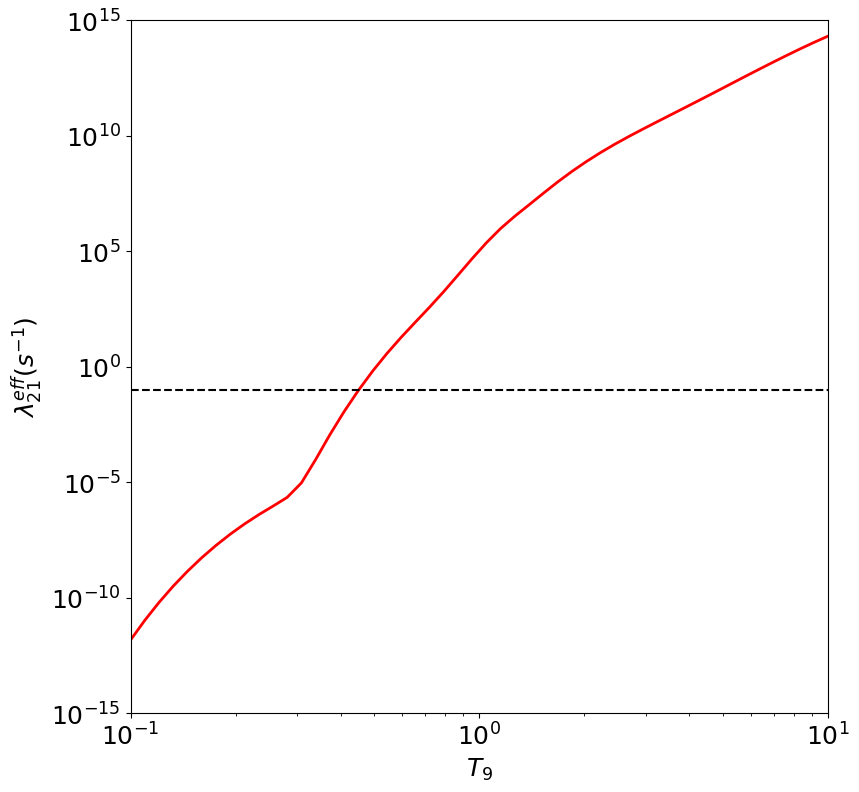

In [94]:
fontsize = 18

plt.figure(figsize = (9,9))
plt.rcParams['font.size'] = fontsize
plt.xscale('log')
plt.yscale('log')

plt.ylim([1.e-15,1.e+15])
plt.xlim([np.min(T)/1e+9,np.max(T)/1e+9])

plt.plot(T/1e+9,lambda_21_eff,color = 'red',linewidth = 2,label = 'Full Calculation')

plt.ylabel(r'$\lambda_{21}^{eff} (s^{-1})$')
plt.xlabel(r'$T_{9}$')

plt.yticks([1e-15,1e-10,1e-5,1e0,1e+5,1e+10,1e+15])

plt.axhline(y = 1.e-1,ls = '--',color = 'black',label = r'$0^{+}$ state $\beta^{-}$ Decay Rate')

#plt.legend()
plt.savefig('rate_comp.png')
plt.show()

In [95]:
'''
levels = sp.get_levels()
transitions = [lt.Transition(levels[2],levels[1],0.0),lt.Transition(levels[3],levels[1],0.0),lt.Transition(levels[5],levels[3],0.0),lt.Transition(levels[14],levels[9],0.0)]

plt.figure(figsize = (9,9))
plt.rcParams['font.size'] = fontsize
plt.xscale('log')
plt.yscale('log')

plt.ylim([1.e-15,1.e+15])
plt.xlim([np.min(T)/1e+9,np.max(T)/1e+9])

plt.plot(T/1e+9,lambda_21_eff,linewidth = 2,label = 'All Transitions')

plt.ylabel(r'$\lambda_{21}^{eff} (s^{-1})$')
plt.xlabel(r'$T_{9}$')

plt.yticks([1e-15,1e-10,1e-5,1e0,1e+5,1e+10,1e+15])

plt.axhline(y = 1.e-1,ls = '--',color = 'black',label = r'$0^{+}$ state $\beta^{-}$ Decay Rate')


for z in range(1,5):
    sp = new_coll.get()['al26']
    for trans in sp.get_transitions():
        i_upper = levels.index(trans.get_upper_level())
        i_lower = levels.index(trans.get_lower_level())

        if i_lower == 1 and i_upper == z + 1:
            sp.remove_transition(trans)
            t = lt.Transition(levels[z+1],levels[1],0.0)
            sp.add_transition(t)
            break
    lambda_21_eff = np.empty(len(T))
    lambda_12_eff = np.empty(len(T)) 
    for j,t in enumerate(T):
        lambda_12_eff[j],lambda_21_eff[j] = lambda_effective(T[j],sp)
    plt.plot(T/1e+9,lambda_21_eff,linewidth = 2,label = 'Transition '+str(z+1)+ ' to 1 disabled')
    

plt.legend()
plt.savefig('transition_band.pdf')
plt.show()
    

#for i in range(len(transitions)):
#    sp = new_coll.get()['al26']
#sp.add_transition(transitions[0])
#lambda_21_eff = np.empty(len(T))
#lambda_12_eff = np.empty(len(T))

#for tr in sp.get_transitions():
#    print('A:', tr.get_Einstein_A())

    #Calculating the effective transition rates
#for j,t in enumerate(T):
#    lambda_12_eff[j],lambda_21_eff[j] = lambda_effective(T[j],sp)
    
#plt.plot(T/1e+9,lambda_21_eff,linewidth = 2)
#plt.legend()
#plt.show()
'''

"\nlevels = sp.get_levels()\ntransitions = [lt.Transition(levels[2],levels[1],0.0),lt.Transition(levels[3],levels[1],0.0),lt.Transition(levels[5],levels[3],0.0),lt.Transition(levels[14],levels[9],0.0)]\n\nplt.figure(figsize = (9,9))\nplt.rcParams['font.size'] = fontsize\nplt.xscale('log')\nplt.yscale('log')\n\nplt.ylim([1.e-15,1.e+15])\nplt.xlim([np.min(T)/1e+9,np.max(T)/1e+9])\n\nplt.plot(T/1e+9,lambda_21_eff,linewidth = 2,label = 'All Transitions')\n\nplt.ylabel(r'$\\lambda_{21}^{eff} (s^{-1})$')\nplt.xlabel(r'$T_{9}$')\n\nplt.yticks([1e-15,1e-10,1e-5,1e0,1e+5,1e+10,1e+15])\n\nplt.axhline(y = 1.e-1,ls = '--',color = 'black',label = r'$0^{+}$ state $\x08eta^{-}$ Decay Rate')\n\n\nfor z in range(1,5):\n    sp = new_coll.get()['al26']\n    for trans in sp.get_transitions():\n        i_upper = levels.index(trans.get_upper_level())\n        i_lower = levels.index(trans.get_lower_level())\n\n        if i_lower == 1 and i_upper == z + 1:\n            sp.remove_transition(trans)\n           

The effective rate could be understood via a combinatorial interpretation. The expression $(f_{1}^{in})^{T}(I - F^{T})^{-1}f_{2}^{out}$ from $\lambda_{21}^{eff}$ is actually the effective branching ratio in terms of Graph Theory. The "cascade probability vectors" are defined as $\Gamma_{q}^{in} = (I - F)^{-1}f_{q}^{in}$. The term cascade refers to the de-excitation from higher states into state 'q'. The paper also defines the 'infinite'-arc generalization of $f_{q}^{out}$ with $\Gamma_{q}^{out} = (I - F^{T})^{-1}f_{q}^{out}$. They then go through the proof to rewrite $\lambda_{21}^{eff} = (\lambda_{2}^{out})^{T}\Gamma_{1}^{in}$.

Other than cleaning up the expression for the effective rates, the $\Gamma$'s play another role, that of calculating the fugacity of each state. Fugacity here deviates away from the pressure definition it uses in thermodynamics, but the term was appropriated due to its description of a state's abundance likeliness to jump to another state with less fugacity. If two states have the same fugacity, they will not exchange abundances. Equilibrium is established when all states have the same fugacity of one.

In [96]:
#Temperature in Kelvin
T = 5e+9

#calculate gamma's

g1_out,g1_in,g2_out,g2_in = gamma_calculator(T,sp)

#time array
n_time = 300
t = np.logspace(-15,-8,n_time)

#equilibrium abundances. The API calculates them for the whole system. For this calculation
#we will use only that for the ground and isomeric state
eq_prob = sp.compute_equilibrium_probabilities(T)

y1_eq = eq_prob[0]
y2_eq = eq_prob[1]

w_1,w_2,W_1,W_2,R_1k,R_2k,G1,G2 = ensemble_weights(eq_prob,g1_in,g2_in)

#initial ensemble abundances. System setup such that the system starts in the ground state.
Y = np.array([1.0,0.0])

#toleranace for Newton-Raphson convergence
tol = 1e-6

#calculating the effective transition rates for the ensemble calculation
l12,l21 = lambda_effective(T,sp)

l12,l21 = l12/W_1,l21/W_2

#evolving the system
Y = newton_raphson(t,tol,Y,l12,l21)
y1eq = W_1*eq_prob[0]
y2eq = W_2*eq_prob[1]

#setting up fugacity matrix as function of time
n_rows = len(eq_prob)

y = np.empty([n_rows,n_time])
y[0,:] = Y[:,0]/W_1
y[1,:] = Y[:,1]/W_2
PHI = np.empty([n_rows,n_time])

PHI[0,:], PHI[1,:] = y[0,:]/y1_eq, y[1,:]/y2_eq

#calculating fugacities based on combination of phi1 and phi2 (eqn 5.8 in paper)
for i in range(n_time):
    PHI[2:n_rows,i] = g1_in*PHI[0,i] + g2_in*PHI[1,i]

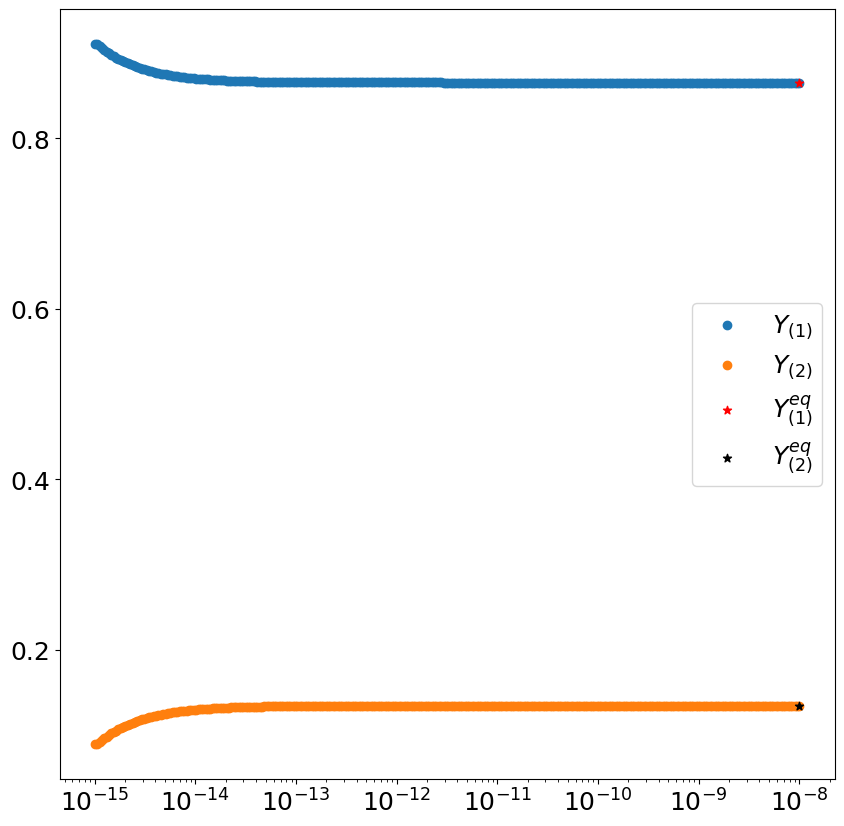

In [97]:
plt.figure(figsize = (10,10))
plt.rcParams['font.size'] = fontsize

plt.scatter(t,Y[:,0],label = r'$Y_{(1)}$')
plt.scatter(t,Y[:,1],label = r'$Y_{(2)}$')
plt.scatter(t[-1],y1eq,marker ='*',color = 'red',label = r'$Y_{(1)}^{eq}$')
plt.scatter(t[-1],y2eq,marker ='*',color = 'black',label = r'$Y_{(2)}^{eq}$')


plt.xscale('log')

plt.legend()
plt.show()

Here we sample over temperatures chosen in table 4 from the paper to compare the values of $W_{1}(T)$, $W_{2}(T)$, $G_{1}(T)$, and $G_{2}(T)$, as well as $\lambda_{21}^{eff}$. By comparing the values to those in the paper, there is good agreement in between the factors listed above for values of $T_{9}$ up to 1.0. The deviation with higher values of and about $T_{9}$ are due to the fact that the xml used contains only 22 levels while the paper's calculation is using 67

In [98]:
T9 = np.array([0.0100,0.0125,0.0150,0.0175,0.0200,0.0250,0.0300,0.0400,0.0500,0.0600,0.0700,0.0800,0.0900,0.1,
               0.125,0.15,0.175,0.2,0.25,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.25,1.5,1.75,2.0,2.5,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0])
n = len(T9)

table = np.empty((n,6))

for i in range(n):
    table[i,0],t9 = T9[i], T9[i]*1e+9
    g1_out,g1_in,g2_out,g2_in = gamma_calculator(t9,sp)
    eqprob = sp.compute_equilibrium_probabilities(t9)
    w_1,w_2,table[i,2],table[i,3],R_1k,R_2k,table[i,4],table[i,5] = ensemble_weights(eqprob,g1_in,g2_in)
    l12,table[i,1] = lambda_effective(t9,sp)

display(Math(r'\;\;\;\;\;\;T_{9} \;\;\;\;\;\;\;\lambda_{21}^{eff} (s^{-1})\;\;\;\;\;  W_{1}(T)\;\;\;\;\;\;\;\; W_{2}(T)\;\;\;\;\;\;\; G_{1}(T)\;\;\;\;\;\;\;G_{2}(T) '))
display(HTML(tabulate.tabulate(table,tablefmt='html',floatfmt=('.4f','.5e','.6f','.6f','.5f','.6f'))))


<IPython.core.display.Math object>

0.0100,4.47694e-98,1.000000,1.000000,11.00000,1.000000
0.0125,4.52544e-79,1.000000,1.000000,11.00000,1.000000
0.0150,2.11567e-66,1.000000,1.000000,11.00000,1.000000
0.0175,2.37299e-57,1.000000,1.000000,11.00000,1.000000
0.0200,1.45439e-50,1.000000,1.000000,11.00000,1.000000
0.0250,4.62404e-41,1.000000,1.000000,11.00000,1.000000
0.0300,9.99804e-35,1.000000,1.000000,11.00000,1.000000
0.0400,8.28956e-27,1.000000,1.000000,11.00000,1.000000
0.0500,4.67414e-22,1.000000,1.000000,11.00000,1.000000
0.0600,6.87303e-19,1.000000,1.000000,11.00000,1.000000
0.0700,1.25780e-16,1.000000,1.000000,11.00000,1.000000


Here we will animate the evolution of the fugacities for the 22 levels in our xml calculated via the ensemble method

In [99]:
'''
fig = plt.figure(figsize = (10,10))
plt.rcParams['font.size'] = fontsize
#extract energies from the levels in the xml
levs = sp.get_levels()
E = np.empty(n_rows)
for i in range(n_rows):
    E[i] = levs[i].get_energy()

def updatefig(i):
    fig.clear()
    fig.suptitle(r'time (s): %8.2e; $T_{9}$ = %4.2f' %(t[i],T/1e+9))
    plt.scatter(PHI[0,i],E[0],color = 'green') #ground state
    plt.scatter(PHI[1,i],E[1],color = 'red') #isomer
    plt.scatter(PHI[2:n_rows-1,i],E[2:len(E)-1],color = 'black')
    plt.axvline(x = PHI[0,i],color = 'green')
    plt.axvline(x = PHI[1,i],color = 'red')
    plt.xlabel(r'$\phi$')
    plt.ylabel('E (keV)')
    plt.xscale('log')
    plt.xlim([1e-8,10])
    plt.draw()

anim = animation.FuncAnimation(fig,updatefig,n_time)
display(HTML(anim.to_jshtml()))
plt.close() #closes the last frame
'''

"\nfig = plt.figure(figsize = (10,10))\nplt.rcParams['font.size'] = fontsize\n#extract energies from the levels in the xml\nlevs = sp.get_levels()\nE = np.empty(n_rows)\nfor i in range(n_rows):\n    E[i] = levs[i].get_energy()\n\ndef updatefig(i):\n    fig.clear()\n    fig.suptitle(r'time (s): %8.2e; $T_{9}$ = %4.2f' %(t[i],T/1e+9))\n    plt.scatter(PHI[0,i],E[0],color = 'green') #ground state\n    plt.scatter(PHI[1,i],E[1],color = 'red') #isomer\n    plt.scatter(PHI[2:n_rows-1,i],E[2:len(E)-1],color = 'black')\n    plt.axvline(x = PHI[0,i],color = 'green')\n    plt.axvline(x = PHI[1,i],color = 'red')\n    plt.xlabel(r'$\\phi$')\n    plt.ylabel('E (keV)')\n    plt.xscale('log')\n    plt.xlim([1e-8,10])\n    plt.draw()\n\nanim = animation.FuncAnimation(fig,updatefig,n_time)\ndisplay(HTML(anim.to_jshtml()))\nplt.close() #closes the last frame\n"

Here we perform the full network calculation of the 22 levels

In [100]:
'''
A = sp.compute_rate_matrix(T)
Y_0 = np.zeros(n_rows)
Y_0[0] = 1.0

Y_result = nefraf_matrix(t,n_rows,tol,Y_0,A)

fugacities = np.empty((Y_result.shape[0], Y_result.shape[1]))

for i in range(n_rows):
    fugacities[i, :] = Y_result[i, :] / eq_prob[i]

fig_1 = plt.figure(figsize = (10,10))
plt.rcParams['font.size'] = fontsize

def updatefig_2(i):
    fig_1.clear()
    fig_1.suptitle(r'time (s): %8.2e; $T_{9}$ = %4.2f' %(t[i],T/1e+9))
    plt.scatter(fugacities[0,i],E[0],color = 'green') #ground state
    plt.scatter(fugacities[1,i],E[1],color = 'red') #isomer
    plt.scatter(fugacities[2:n_rows-1,i],E[2:len(E)-1],color = 'black')
    plt.axvline(x = fugacities[0,i],color = 'green')
    plt.axvline(x = fugacities[1,i],color = 'red')
    plt.xlabel(r'$\phi$')
    plt.ylabel('E (keV)')
    plt.xscale('log')
    plt.xlim([1e-15,1e+2])
    plt.draw()

anim = animation.FuncAnimation(fig_1,updatefig_2,n_time)
display(HTML(anim.to_jshtml()))
plt.close() #closes the last frame
'''

"\nA = sp.compute_rate_matrix(T)\nY_0 = np.zeros(n_rows)\nY_0[0] = 1.0\n\nY_result = nefraf_matrix(t,n_rows,tol,Y_0,A)\n\nfugacities = np.empty((Y_result.shape[0], Y_result.shape[1]))\n\nfor i in range(n_rows):\n    fugacities[i, :] = Y_result[i, :] / eq_prob[i]\n\nfig_1 = plt.figure(figsize = (10,10))\nplt.rcParams['font.size'] = fontsize\n\ndef updatefig_2(i):\n    fig_1.clear()\n    fig_1.suptitle(r'time (s): %8.2e; $T_{9}$ = %4.2f' %(t[i],T/1e+9))\n    plt.scatter(fugacities[0,i],E[0],color = 'green') #ground state\n    plt.scatter(fugacities[1,i],E[1],color = 'red') #isomer\n    plt.scatter(fugacities[2:n_rows-1,i],E[2:len(E)-1],color = 'black')\n    plt.axvline(x = fugacities[0,i],color = 'green')\n    plt.axvline(x = fugacities[1,i],color = 'red')\n    plt.xlabel(r'$\\phi$')\n    plt.ylabel('E (keV)')\n    plt.xscale('log')\n    plt.xlim([1e-15,1e+2])\n    plt.draw()\n\nanim = animation.FuncAnimation(fig_1,updatefig_2,n_time)\ndisplay(HTML(anim.to_jshtml()))\nplt.close() #closes

Here we overlay both animations to compare. The empty circles are the ensemble calculation

In [101]:
'''
fig_2 = plt.figure(figsize  =(10,10))
plt.rcParams['font.size'] = fontsize

def updatefig_3(i):
    fig_2.clear()
    fig_2.suptitle(r'time (s): %8.2e; $T_{9}$ = %4.2f' %(t[i],T/1e+9))
    plt.scatter(fugacities[0,i],E[0],color = 'green',) #ground state
    plt.scatter(fugacities[1,i],E[1],color = 'red') #isomer
    plt.scatter(fugacities[2:n_rows-1,i],E[2:len(E)-1],color = 'black')
    plt.axvline(x = fugacities[0,i],color = 'green')
    plt.axvline(x = fugacities[1,i],color = 'red')

    #empty circles indicate the ensemble calculation###################
    #plt.scatter(PHI[0,i],E[0],facecolors = 'none',color = 'green') #ground state
    #plt.scatter(PHI[1,i],E[1],facecolors = 'none',color = 'red') #isomer
    plt.scatter(PHI[2:n_rows-1,i],E[2:len(E)-1],facecolors = 'none',color = 'black')
    #plt.axvline(x = PHI[0,i],color = 'green')
    #plt.axvline(x = PHI[1,i],color = 'red')
    ######################################################################



    plt.xlabel(r'$\phi$')
    plt.ylabel('E (keV)')
    plt.xscale('log')
    plt.xlim([1e-15,1e+2])
    plt.draw()

anim = animation.FuncAnimation(fig_2,updatefig_3,n_time)
display(HTML(anim.to_jshtml()))
plt.close() #closes the last frame
'''

"\nfig_2 = plt.figure(figsize  =(10,10))\nplt.rcParams['font.size'] = fontsize\n\ndef updatefig_3(i):\n    fig_2.clear()\n    fig_2.suptitle(r'time (s): %8.2e; $T_{9}$ = %4.2f' %(t[i],T/1e+9))\n    plt.scatter(fugacities[0,i],E[0],color = 'green',) #ground state\n    plt.scatter(fugacities[1,i],E[1],color = 'red') #isomer\n    plt.scatter(fugacities[2:n_rows-1,i],E[2:len(E)-1],color = 'black')\n    plt.axvline(x = fugacities[0,i],color = 'green')\n    plt.axvline(x = fugacities[1,i],color = 'red')\n\n    #empty circles indicate the ensemble calculation###################\n    #plt.scatter(PHI[0,i],E[0],facecolors = 'none',color = 'green') #ground state\n    #plt.scatter(PHI[1,i],E[1],facecolors = 'none',color = 'red') #isomer\n    plt.scatter(PHI[2:n_rows-1,i],E[2:len(E)-1],facecolors = 'none',color = 'black')\n    #plt.axvline(x = PHI[0,i],color = 'green')\n    #plt.axvline(x = PHI[1,i],color = 'red')\n    ######################################################################\n\n\n\n 

Here we compare the evolution of the isomer via a network calculation against the evolution of the ensemble connected to the isomer. The solid line is the full network calculation while the dashed line is the ensemble calculation

In [102]:
'''
T9 = np.array([0.2,2.0,1.0,5.0])
plt.figure(figsize = (12,12))
plt.rcParams['font.size'] = fontsize

for i in range(len(T9)):
    if i == 0:
        t = np.logspace(-15,10,300)
    elif i == 1:
        t = np.logspace(-11,-7,300)
    elif i == 2:
        t = np.logspace(-10,-4,300)
    else:
        t = np.logspace(-13,-9.5,300)
     
    rate_matrix = sp.compute_rate_matrix(T9[i]*1e+9)
    g1_out,g1_in,g2_out,g2_in = gamma_calculator(T9[i]*1e+9,sp)
    eq_prob = sp.compute_equilibrium_probabilities(T9[i]*1e+9)
    w_1,w_2,W_1,W_2,R_1k,R_2k,G1,G2 = ensemble_weights(eq_prob,g1_in,g2_in)
    
    #full network calculation
    y_net = np.zeros(n_rows)
    y_net[0] = 1.0
    y_net = nefraf_matrix(t,n_rows,tol,y_net,rate_matrix)

    #ensemble calculation
    l12,l21 = lambda_effective(T9[i]*1e+9,sp)
    l12,l21 = l12/W_1,l21/W_2
    y_ens = np.array([1.0,0.0])
    y_ens = newton_raphson(t,tol,y_ens,l12,l21)

    #network ensemble calculation
    y_2_net = np.empty(len(t))
    for m in range(len(t)):
        y_2_net[m] = y_net[1,m]
        for k in range(2,n_rows):
            y_2_net[m] += w_2[k-2]*y_net[1,m]*y_net[k,m]/(w_1[k-2]*y_net[0,m] + w_2[k-2]*y_net[1,m])
    
    #assign subplot and graph
    subplot_number = int('22'+str(i+1))
    plt.subplot(subplot_number)
    plt.title(r'$T_{9}$ = '+str(T9[i]))
    plt.plot(t,y_2_net,color = 'black')
    plt.plot(t,y_ens[:,1],'--',color = 'red')
    plt.plot()
    plt.yscale('log')
    plt.xscale('log')
    plt.xlim((np.min(t),np.max(t)))
    plt.xlabel('Time (s)')
    plt.ylabel(r'$Y_{(2)}$')

plt.tight_layout()
plt.show() 
'''

"\nT9 = np.array([0.2,2.0,1.0,5.0])\nplt.figure(figsize = (12,12))\nplt.rcParams['font.size'] = fontsize\n\nfor i in range(len(T9)):\n    if i == 0:\n        t = np.logspace(-15,10,300)\n    elif i == 1:\n        t = np.logspace(-11,-7,300)\n    elif i == 2:\n        t = np.logspace(-10,-4,300)\n    else:\n        t = np.logspace(-13,-9.5,300)\n     \n    rate_matrix = sp.compute_rate_matrix(T9[i]*1e+9)\n    g1_out,g1_in,g2_out,g2_in = gamma_calculator(T9[i]*1e+9,sp)\n    eq_prob = sp.compute_equilibrium_probabilities(T9[i]*1e+9)\n    w_1,w_2,W_1,W_2,R_1k,R_2k,G1,G2 = ensemble_weights(eq_prob,g1_in,g2_in)\n    \n    #full network calculation\n    y_net = np.zeros(n_rows)\n    y_net[0] = 1.0\n    y_net = nefraf_matrix(t,n_rows,tol,y_net,rate_matrix)\n\n    #ensemble calculation\n    l12,l21 = lambda_effective(T9[i]*1e+9,sp)\n    l12,l21 = l12/W_1,l21/W_2\n    y_ens = np.array([1.0,0.0])\n    y_ens = newton_raphson(t,tol,y_ens,l12,l21)\n\n    #network ensemble calculation\n    y_2_net = 

As mentioned, the isomer indirectly transitions to the ground state by getting excited to higher states which have smaller spin differences with the ground state. Those in turn de-excite into the latter. To show the path taken through the upper levels, generate a graph containing the levels as nodes and the inverse transition rates as the weights connecting the nodes. The method to solve for the shortest paths is [Dijkstra's Algorithm](https://en.wikipedia.org/wiki/Dijkstra%27s_algorithm)

/tmp/ipykernel_23304/1769803296.py:302: RuntimeWarning: divide by zero encountered in scalar divide
  G[i_upper].append((i_lower,1.0/rate_matrix[i_lower,i_upper]))
/tmp/ipykernel_23304/1769803296.py:303: RuntimeWarning: divide by zero encountered in scalar divide
  G[i_lower].append((i_upper,1.0/rate_matrix[i_upper,i_lower]))


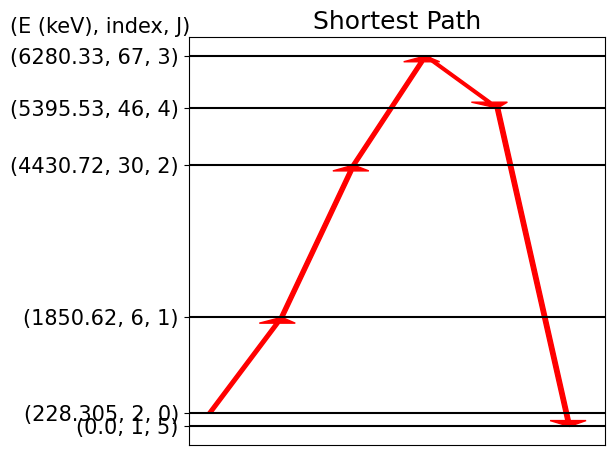

In [120]:
#set the temperature
T = 5e+9
levs = sp.get_levels()
#obtain the graph
G = graph(sp,T)
#calculate the 1st 5 shortest paths. Note that you can pass how many paths you want with the 'num_paths' variable.
#the default is 5
shortest_paths = dijkstra(G,1,0)

#graph the shortest path
path = shortest_paths[0][0]
#plt.figure(figsize = (9,9))
n_path = len(path) #total number of transitions
max_energy = max(path) #index of maximum energy level for transition
tick_labels = []
tick_values = []
for i,en in enumerate(path):
    energy = levs[path[i]].get_energy()
    J = int((levs[path[i]].get_multiplicity() - 1)/2)
    plt.axhline(y = energy,color = 'black')
    tick_labels.append('('+str(energy) + ', '+str(en+1)+', '+str(J)+')')
    tick_values.append(energy)
    


for i in range(n_path-1):
    en_f = levs[path[i+1]].get_energy()
    en_i = levs[path[i]].get_energy()
    delta_E =  en_f - en_i 
    plt.arrow(i/(n_path-1),en_i,1/(n_path - 1),delta_E,color = 'red',width = 0.0125,length_includes_head = True, 
              head_length = 100,head_width = 0.1)
plt.ylabel('(E (keV), index, J)',ha = 'left', y = 1, rotation = 0,labelpad = 0)

plt.yticks(ticks = tick_values,labels = tick_labels)
plt.tick_params(axis = 'x', which ='both',bottom = False, top = False,labelbottom = False)
plt.title('Shortest Path')

plt.tight_layout()
plt.show()

Here we graph the 5 shortest path in ascending order of path length. The leftmost path will be the shortest.

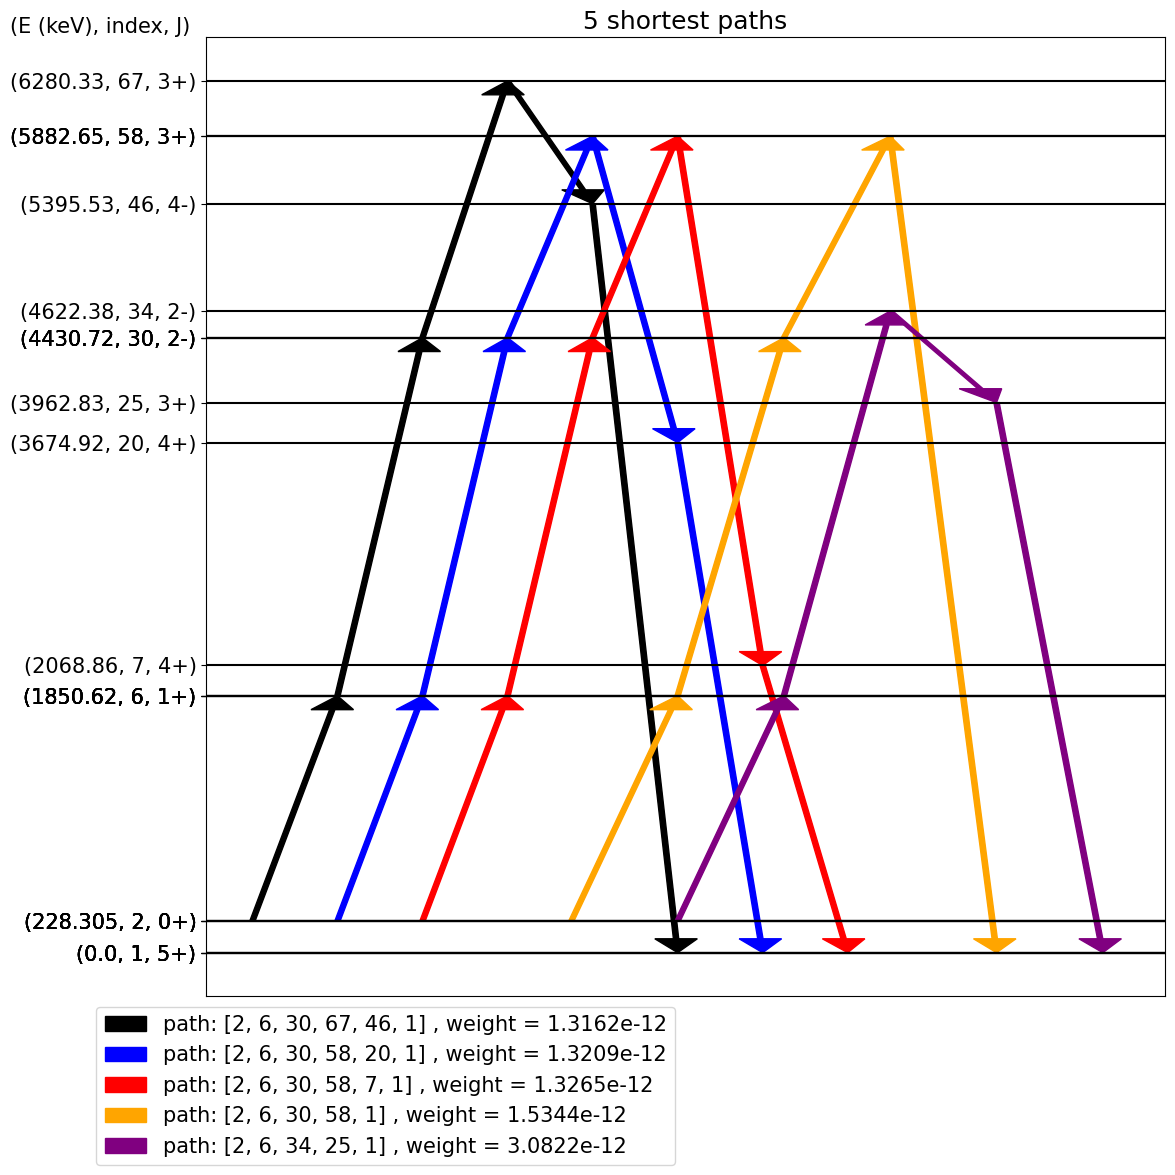

In [121]:
#graphing the 5 shortest paths based on weight
plt.figure(figsize = (12,12))
plt.rcParams['font.size'] = 15

tick_labels = []
tick_values = []

colors = ['black','blue','red','orange','purple']
for j,(path,weight) in enumerate(shortest_paths):
    plot_legend = []
    n_path = len(path) #total number of transitions
    max_energy = max(path) #index of maximum energy level for transition
    
    for i,en in enumerate(path):
        energy = levs[path[i]].get_energy()
        J = int((levs[path[i]].get_multiplicity() - 1)/2)
        
        #to avoid line and label duplicates in the plot
        if '('+str(energy) + ', '+str(en+1)+', '+str(J) +')' not in tick_labels:
            
            plt.axhline(y = energy,color = 'black')
            tick_labels.append('('+str(energy) + ', '+str(en+1)+', '+str(J)+levs[path[i]].get_properties()['parity']+')')
            tick_values.append(energy)
    


    for i in range(n_path-1):
        en_f = levs[path[i+1]].get_energy()
        en_i = levs[path[i]].get_energy()
        delta_E =  en_f - en_i 
        
        if i != n_path-2:
            plot_legend.append(path[i] + 1)
            plt.arrow((i+j)/(n_path-1),en_i,1/(n_path - 1),delta_E,color = colors[j],width = 0.0125,length_includes_head = True, 
                    head_length = 100,head_width = 0.1) 
        else:
            plot_legend.append(path[i] + 1)
            plot_legend.append(path[i+1] + 1)
            plt.arrow((i+j)/(n_path-1),en_i,1/(n_path - 1),delta_E,color = colors[j],width = 0.0125,length_includes_head = True, 
                    head_length = 100,head_width = 0.1,label = 'path: '+str(plot_legend)+' , weight = %3.4e'%(weight)) 

plt.yticks(ticks = tick_values,labels = tick_labels)
plt.tick_params(axis = 'x', which ='both',bottom = False, top = False,labelbottom = False) 

plt.ylabel('(E (keV), index, J)',ha = 'left', y = 1, rotation = 0,labelpad = 0)
plt.title('5 shortest paths')
plt.legend(bbox_to_anchor=(0.5,0))
plt.tight_layout()
plt.show()


The below function is a Weisskopf estimator for calculating the Einstein A coefficient for missing transitions from the XML file. There exist versions to handle specific magnetic spin and dielectric shifts, but since the XML this notebook focuses on has none of that information, we focus on an estimator that does only angular momentum transitions.

In [122]:

'''

#Temperature Range in K
T = np.logspace(8,10)

#initializing the rate arrays as a function of temperature
lambda_21_eff = np.empty(len(T))
lambda_12_eff = np.empty(len(T))

lambda_21_eff_en = np.empty(len(T))
lambda_12_eff_en = np.empty(len(T))

#Calculating the effective transition rates
for i,t in enumerate(T):
    print(i)
    lambda_12_eff[i],lambda_21_eff[i] = lambda_effective(T[i],sp)
    lambda_12_eff_en[i],lambda_21_eff_en[i] = lambda_effective(T[i],al26_ensdf)


'''

'\n\n#Temperature Range in K\nT = np.logspace(8,10)\n\n#initializing the rate arrays as a function of temperature\nlambda_21_eff = np.empty(len(T))\nlambda_12_eff = np.empty(len(T))\n\nlambda_21_eff_en = np.empty(len(T))\nlambda_12_eff_en = np.empty(len(T))\n\n#Calculating the effective transition rates\nfor i,t in enumerate(T):\n    print(i)\n    lambda_12_eff[i],lambda_21_eff[i] = lambda_effective(T[i],sp)\n    lambda_12_eff_en[i],lambda_21_eff_en[i] = lambda_effective(T[i],al26_ensdf)\n\n\n'

/tmp/ipykernel_23304/1769803296.py:302: RuntimeWarning: divide by zero encountered in scalar divide
  G[i_upper].append((i_lower,1.0/rate_matrix[i_lower,i_upper]))
/tmp/ipykernel_23304/1769803296.py:303: RuntimeWarning: divide by zero encountered in scalar divide
  G[i_lower].append((i_upper,1.0/rate_matrix[i_upper,i_lower]))


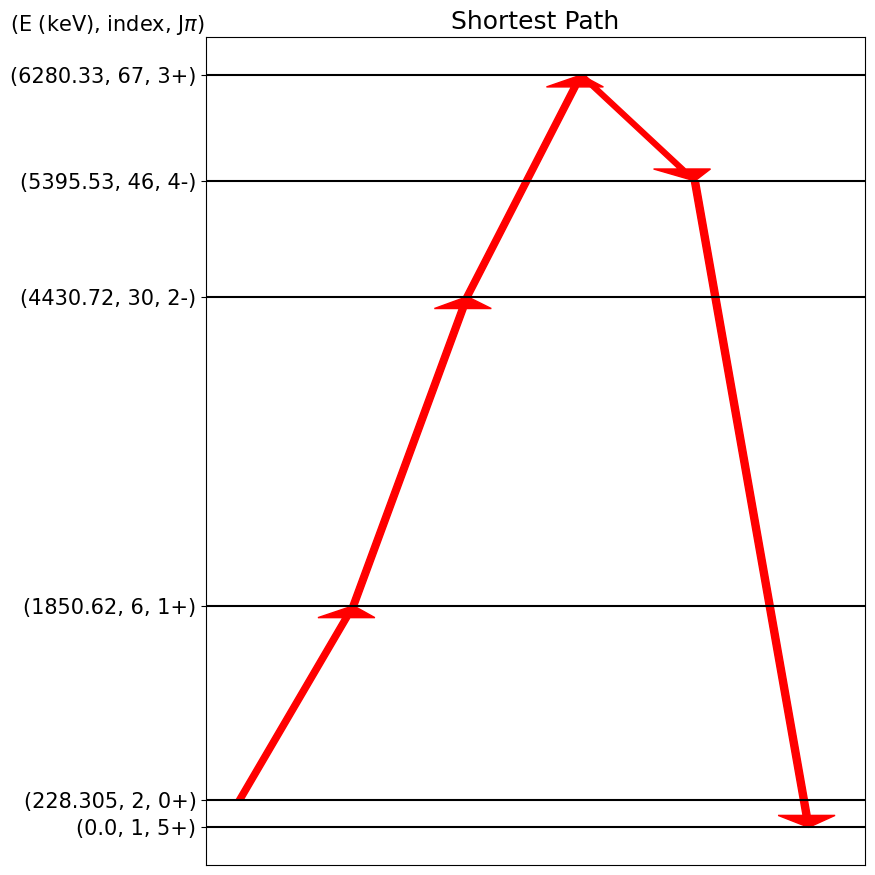

In [123]:
#set the temperature
T = 5e+9
levels = sp.get_levels()
#obtain the graph
G = graph(sp,T)
#calculate the 1st 5 shortest paths. Note that you can pass how many paths you want with the 'num_paths' variable.
#the default is 5
shortest_paths = dijkstra(G,1,0)

#graph the shortest path
path = shortest_paths[0][0]
plt.figure(figsize = (9,9))
n_path = len(path) #total number of transitions
max_energy = max(path) #index of maximum energy level for transition
tick_labels = []
tick_values = []
for i,en in enumerate(path):
    energy = levels[path[i]].get_energy()
    J = int((levels[path[i]].get_multiplicity() - 1)/2)
    plt.axhline(y = energy,color = 'black')
    tick_labels.append('('+str(energy) + ', '+str(en+1)+', '+str(J)+levels[path[i]].get_properties()['parity']+')')
    tick_values.append(energy)
    


for i in range(n_path-1):
    en_f = levels[path[i+1]].get_energy()
    en_i = levels[path[i]].get_energy()
    delta_E =  en_f - en_i 
    plt.arrow(i/(n_path-1),en_i,1/(n_path - 1),delta_E,color = 'red',width = 0.0125,length_includes_head = True, 
              head_length = 100,head_width = 0.1)
plt.ylabel(r'(E (keV), index, J$\pi$)',ha = 'left', y = 1, rotation = 0,labelpad = 0)

plt.yticks(ticks = tick_values,labels = tick_labels)
plt.tick_params(axis = 'x', which ='both',bottom = False, top = False,labelbottom = False)
plt.title('Shortest Path')

plt.tight_layout()
plt.savefig('al26_ensdf_shortest_path.png')
plt.show()

In [124]:
ta180 = new_coll1.get()['ta180']
trns = ta180.get_transitions()
levels = ta180.get_levels()
A = 180 
'''
#creating the 2D array
transitions = np.empty((len(trn),2),dtype = int)
#filling up the array
for k,trans in enumerate(trns):
    i_upper = levels.index(trans.get_upper_level())
    i_lower = levels.index(trans.get_lower_level())
    transitions[k,0],transitions[k,1] = i_upper,i_lower   

for i in range(1, len(levels)): #starting at 1 since no self transitions don't exist
    for j in range(i,0,-1):
        test_trans = [i,j-1]
        if test_trans not in transitions.tolist():
            E_i = levels[i].get_energy()
            E_f = levels[j-1].get_energy()

            J_i = (levels[i].get_multiplicity() - 1)/2
            J_f = (levels[j-1].get_multiplicity() - 1)/2


            P_i = levels[i].get_properties()['parity'] #parity of initial state
            P_f = levels[j-1].get_properties()['parity'] #parity of final state

            if P_i == '+':
                P_i = 1
            else:
                P_i = -1
        
            if P_f == '+':
                P_f = 1
            else:
                P_f = -1

            ein_A = weisskopf_estimate(E_i,E_f,J_i,J_f,P_i,P_f,A)
            t = lt.Transition(levels[i],levels[j-1],ein_A)
            ta180.add_transition(t)

transitions = ta180.get_transitions()
for tran in transitions:
    i_upper = levels.index(tran.get_upper_level())
    i_lower = levels.index(tran.get_lower_level())
    ein_A = tran.get_Einstein_A()

    print(i_upper,i_lower, ein_A)
'''

NameError: name 'new_coll1' is not defined

In [ ]:
T = np.logspace(7,10)

#initializing the rate arrays as a function of temperature
lambda_21_eff = np.empty(len(T))
lambda_12_eff = np.empty(len(T))

#Calculating the effective transition rates
for i,t in enumerate(T):
    print(i)
    lambda_12_eff[i],lambda_21_eff[i] = lambda_effective(T[i],ta180)


    

In [ ]:
fontsize = 18
print(lambda_21_eff)

plt.figure(figsize = (9,9))
plt.rcParams['font.size'] = fontsize
plt.xscale('log')
plt.yscale('log')

#plt.ylim([1.e-15,1.e+15])
#plt.xlim([np.min(T)/1e+9,np.max(T)/1e+9])

plt.plot(T/1e+9,lambda_21_eff,color = 'red',linewidth = 2,label = r'$^{180}Ta$')


plt.ylabel(r'$\lambda_{21}^{eff} (s^{-1})$')
plt.xlabel(r'$T_{9}$')

#plt.yticks([1e-15,1e-10,1e-5,1e0,1e+5,1e+10,1e+15])
plt.suptitle('Transition Rate From Isomer to Ground State')
plt.legend()

plt.savefig('ta180_rate.png')
plt.show()

In [ ]:
kr85 = new_coll1.get()['kr85']
'''
trns = kr85.get_transitions()
levels = kr85.get_levels()
A = 85 
#creating the 2D array
transitions = np.empty((len(trn),2),dtype = int)
#filling up the array
for k,trans in enumerate(trns):
    i_upper = levels.index(trans.get_upper_level())
    i_lower = levels.index(trans.get_lower_level())
    transitions[k,0],transitions[k,1] = i_upper,i_lower   

for i in range(1, len(levels)): #starting at 1 since no self transitions don't exist
    for j in range(i,0,-1):
        test_trans = [i,j-1]
        if test_trans not in transitions.tolist():
            E_i = levels[i].get_energy()
            E_f = levels[j-1].get_energy()

            J_i = (levels[i].get_multiplicity() - 1)/2
            J_f = (levels[j-1].get_multiplicity() - 1)/2


            P_i = levels[i].get_properties()['parity'] #parity of initial state
            P_f = levels[j-1].get_properties()['parity'] #parity of final state

            if P_i == '+':
                P_i = 1
            else:
                P_i = -1
        
            if P_f == '+':
                P_f = 1
            else:
                P_f = -1

            ein_A = weisskopf_estimate(E_i,E_f,J_i,J_f,P_i,P_f,A)
            t = lt.Transition(levels[i],levels[j-1],ein_A)
            kr85.add_transition(t)

transitions = kr85.get_transitions()
for tran in transitions:
    i_upper = levels.index(tran.get_upper_level())
    i_lower = levels.index(tran.get_lower_level())
    ein_A = tran.get_Einstein_A()

    print(i_upper,i_lower, ein_A)
'''
T = np.logspace(7,10)

#initializing the rate arrays as a function of temperature
lambda_21_eff = np.empty(len(T))
lambda_12_eff = np.empty(len(T))

#Calculating the effective transition rates
for i,t in enumerate(T):
    print(i)
    lambda_12_eff[i],lambda_21_eff[i] = lambda_effective(T[i],kr85)

fontsize = 18
print(lambda_21_eff)

plt.figure(figsize = (9,9))
plt.rcParams['font.size'] = fontsize
plt.xscale('log')
plt.yscale('log')

#plt.ylim([1.e-15,1.e+15])
#plt.xlim([np.min(T)/1e+9,np.max(T)/1e+9])

plt.plot(T/1e+9,lambda_21_eff,color = 'red',linewidth = 2,label = r'$^{85}Kr$')


plt.ylabel(r'$\lambda_{21}^{eff} (s^{-1})$')
plt.xlabel(r'$T_{9}$')

#plt.yticks([1e-15,1e-10,1e-5,1e0,1e+5,1e+10,1e+15])
plt.suptitle('Transition Rate From Isomer to Ground State')
plt.legend()

plt.savefig('kr85_rate.png')
plt.show()


In [ ]:
import wnutils.xml as wx

xml = wx.Xml('new_net.xml')
reacs = xml.get_reaction_data("[reactant = 'kr85m']")
r = reacs['kr85m + gamma -> kr85g']
t9s = np.logspace(-2,1)
rate = r.compute_rate(t9s)
plt.plot(t9s, rate,label = 'Wendel\'s Rate')
plt.plot(T/1e+9,lambda_21_eff,color = 'red',linewidth = 2,label = r'$^{85}Kr$ from ENSDF')

plt.yscale('log')
plt.xscale('log')
plt.xlim([1e-1,10])

plt.ylim([1.e-18,1.e+15])
plt.legend()

plt.plot()
plt.savefig('kr85_comp.png')
plt.show()

In [ ]:
levs = al26_ensdf.get_levels()
#graphing the 5 shortest paths based on weight
plt.figure(figsize = (10,10))
plt.rcParams['font.size'] = 15

tick_labels = []
tick_values = []

colors = ['black','blue','red','orange','purple']
for j,(path,weight) in enumerate(shortest_paths):
    plot_legend = []
    n_path = len(path) #total number of transitions
    max_energy = max(path) #index of maximum energy level for transition
    
    for i,en in enumerate(path):
        energy = levs[path[i]].get_energy()
        J = int((levs[path[i]].get_multiplicity() - 1)/2)
        
        #to avoid line and label duplicates in the plot
        if '('+str(energy) + ', '+str(en+1)+', '+str(J)+levs[path[i]].get_properties()['parity']+')' not in tick_labels:
            
            plt.axhline(y = energy,color = 'black')
            tick_labels.append('('+str(energy) + ', '+str(en+1)+', '+str(J)+levs[path[i]].get_properties()['parity']+')')
            tick_values.append(energy)
    


    for i in range(n_path-1):
        en_f = levs[path[i+1]].get_energy()
        en_i = levs[path[i]].get_energy()
        delta_E =  en_f - en_i 
        
        if i != n_path-2:
            plot_legend.append(path[i] + 1)
            plt.arrow((i+j)/(n_path-1),en_i,1/(n_path - 1),delta_E,color = colors[j],width = 0.0125,length_includes_head = True, 
                    head_length = 100,head_width = 0.1) 
        else:
            plot_legend.append(path[i] + 1)
            plot_legend.append(path[i+1] + 1)
            plt.arrow((i+j)/(n_path-1),en_i,1/(n_path - 1),delta_E,color = colors[j],width = 0.0125,length_includes_head = True, 
                    head_length = 100,head_width = 0.1,label = 'path: '+str(plot_legend)+' , weight = '+str(weight)) 

plt.yticks(ticks = tick_values,labels = tick_labels)
plt.tick_params(axis = 'x', which ='both',bottom = False, top = False,labelbottom = False) 

plt.ylabel('(E (keV), index, J)',ha = 'left', y = 1, rotation = 0,labelpad = 0)
plt.title('5 shortest paths')
plt.legend(bbox_to_anchor=(1,0.5))
plt.tight_layout()
plt.savefig('al26_5_shortest.png')
plt.show()


In [ ]:
rm = al26_ensdf.compute_rate_matrix(5e+9)
for i in range (len(rm)):
    print(rm[i,:])

In [ ]:
import networkx as nx

G = nx.Graph()

tranz = al26_ensdf.get_transitions()
levels = al26_ensdf.get_levels()
rate_matrix = al26_ensdf.compute_rate_matrix(5e+9)

for tran in tranz:
    i_upper = levels.index(tran.get_upper_level())
    i_lower = levels.index(tran.get_lower_level())

    G.add_edge(i_upper,i_lower, weight = 1.0/rate_matrix[i_lower,i_upper])
    G.add_edge(i_lower,i_upper, weight = 1.0/rate_matrix[i_upper,i_lower])

path = nx.shortest_path(G,1,0,weight = 'weight')
print(path)


In [ ]:
paths = nx.all_shortest_paths(G,1,0,weight='weight')

for k in paths:
    print(k)

In [126]:
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import shortest_path
rm = sp.compute_rate_matrix(5e+9)
graph = csr_matrix(rm)

dist_matrix = shortest_path(graph,directed = False,return_predecessors=False,)
print(dist_matrix[1,0])

4.9877851126106956e-18


In [128]:
import networkx as nx

G = nx.from_numpy_array(rm)

nx.shortest_path(G,1,0)

[1, 0]